In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import laplace
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from batchbald_redux import repeated_mnist, active_learning, batchbald
from main.models import BayesianConvNet, ConvNet
from main.utils import save_experiment, load_experiment
from laplace.curvature import BackPackGGN


%reload_ext autoreload
%autoreload 2

## Data and experiment parameters

In [10]:
# loading data
train_dataset, test_dataset = repeated_mnist.create_MNIST_dataset()

# number of initial samples 
num_initial_samples = 40
num_classes = 10

# get indices of initial samples
initial_samples = active_learning.get_balanced_sample_indices(
    repeated_mnist.get_targets(train_dataset), num_classes=num_classes, n_per_digit=num_initial_samples / num_classes
)

# Experiment parameters

## Active learning parameters
max_training_samples = 100  # Maximum number of samples to acquire from the pool dataset 
acquisition_batch_size = 5  # Number of samples to acquire in each acquisition step

## Training parameters
test_batch_size = 512  # Batch size for testing
batch_size = 64  # Batch size for training
scoring_batch_size = 64  # Batch size for scoring 
training_iterations_nn = 4096 * 6  # Number of training iterations (batches) to run
training_iterations_la = 2024  # Number of training iterations (batches) to run

## Model parameters
hessian_structure = "kron"  # Options: "full", "kron", "lowrank" and "diag"
subset_of_weights = "last_layer"  # Options: "all", "subnetwork" and "last_layer"

kwargs = {"num_workers": 1, "pin_memory": True}

use_cuda = torch.cuda.is_available()
device = "cuda" if use_cuda else "cpu"

print(f"use_cuda: {use_cuda}")

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, **kwargs)

active_learning_data = active_learning.ActiveLearningData(train_dataset)

# Split off the initial samples first.
active_learning_data.acquire(initial_samples)

# THIS REMOVES MOST OF THE POOL DATA. UNCOMMENT THIS TO TAKE ALL UNLABELLED DATA INTO ACCOUNT!
active_learning_data.extract_dataset_from_pool(55000)

train_loader_nn = torch.utils.data.DataLoader(
    active_learning_data.training_dataset,
    sampler=active_learning.RandomFixedLengthSampler(active_learning_data.training_dataset, training_iterations_nn),
    batch_size=batch_size,
    **kwargs,
)

train_loader_la = torch.utils.data.DataLoader(
    active_learning_data.training_dataset,
    sampler=active_learning.RandomFixedLengthSampler(active_learning_data.training_dataset, training_iterations_nn),
    batch_size=batch_size,
    **kwargs,
)

pool_loader = torch.utils.data.DataLoader(
    active_learning_data.pool_dataset, batch_size=scoring_batch_size, shuffle=False, **kwargs
)

use_cuda: False


c:\Users\vince\Documents\Statistics\TT\msc_thesis\.venv\Lib\site-packages\torch\utils\data\sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


## Running Experiment

In [12]:
# Run experiment
test_accs = []
test_loss = []
added_indices = []

pbar = tqdm(initial=len(active_learning_data.training_dataset), total=max_training_samples, desc="Training Set Size")
loss_fn = nn.NLLLoss()

while True:
    model = ConvNet().to(device=device)
    optimizer = torch.optim.Adam(model.parameters())

    model.train()

    # Train
    for data, target in tqdm(train_loader_nn, desc="Training", leave=False):
        data = data.to(device=device)
        target = target.to(device=device)

        optimizer.zero_grad()

        prediction = F.log_softmax(model(data).squeeze(1), dim=1)
        loss = loss_fn(prediction, target)

        loss.backward()
        optimizer.step()

    # Test
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Testing", leave=False):
            data = data.to(device=device)
            target = target.to(device=device)

            prediction = model(data).squeeze(1)
            loss += loss_fn(prediction, target)

            prediction = prediction.argmax(dim=1)
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    loss /= len(test_loader.dataset)
    test_loss.append(loss)

    percentage_correct = 100.0 * correct / len(test_loader.dataset)
    test_accs.append(percentage_correct)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
            loss, correct, len(test_loader.dataset), percentage_correct
        )
    )

    if len(active_learning_data.training_dataset) >= max_training_samples:
        break

    # Acquire new batch from pool samples using random acquisition
    N = len(active_learning_data.pool_dataset)

    
    scores = torch.zeros(acquisition_batch_size)
    indices = list(np.random.choice(N, acquisition_batch_size, replace=False))
    candidate_batch = batchbald.CandidateBatch(scores=scores, indices=indices)

    targets = repeated_mnist.get_targets(active_learning_data.pool_dataset)
    dataset_indices = active_learning_data.get_dataset_indices(candidate_batch.indices)

    print("Dataset indices: ", dataset_indices)
    print("Scores: ", candidate_batch.scores)
    print("Labels: ", targets[candidate_batch.indices])

    active_learning_data.acquire(candidate_batch.indices)
    added_indices.append(dataset_indices)
    pbar.update(len(dataset_indices))

Training Set Size:  40%|████      | 40/100 [02:24<?, ?it/s]
                                                           

Test set: Average loss: -0.0256, Accuracy: 7162/10000 (71.62%)
Dataset indices:  [18164 38751 28106 48431 34050]
Scores:  tensor([0., 0., 0., 0., 0.])
Labels:  tensor([2, 1, 7, 3, 5])


Test set: Average loss: -0.0238, Accuracy: 7224/10000 (72.24%)
Dataset indices:  [26721   191  3403  6467 29237]
Scores:  tensor([0., 0., 0., 0., 0.])
Labels:  tensor([7, 5, 6, 3, 3])


Test set: Average loss: -0.0192, Accuracy: 7336/10000 (73.36%)
Dataset indices:  [35254 24379 51343 12455 33720]
Scores:  tensor([0., 0., 0., 0., 0.])
Labels:  tensor([4, 9, 3, 8, 4])


Test set: Average loss: -0.0187, Accuracy: 7802/10000 (78.02%)
Dataset indices:  [30570 52803 47686 51497 48115]
Scores:  tensor([0., 0., 0., 0., 0.])
Labels:  tensor([2, 7, 2, 6, 8])


Test set: Average loss: -0.0246, Accuracy: 7948/10000 (79.48%)
Dataset indices:  [50179 52411 58643 17172 57402]
Scores:  tensor([0., 0., 0., 0., 0.])
Labels:  tensor([8, 1, 8, 5, 3])


Test set: Average loss: -0.0260, Accuracy: 8000/10000 (80.00%)
Dataset indices:  [ 6746 58918 25952 12999   391]
Scores:  tensor([0., 0., 0., 0., 0.])
Labels:  tensor([8, 9, 0, 9, 2])


Test set: Average loss: -0.0278, Accuracy: 8060/10000 (80.60%)
Dataset indices:  [45370 20928 51656 29548  7743]
Scores:  tensor([0., 0., 0., 0., 0.])
Labels:  tensor([9, 0, 8, 6, 2])


Test set: Average loss: -0.0317, Accuracy: 8217/10000 (82.17%)
Dataset indices:  [54128 21007  8865 23413 30953]
Scores:  tensor([0., 0., 0., 0., 0.])
Labels:  tensor([2, 3, 3, 1, 4])


Test set: Average loss: -0.0354, Accuracy: 8414/10000 (84.14%)
Dataset indices:  [25290 41022 49330  1948 20466]
Scores:  tensor([0., 0., 0., 0., 0.])
Labels:  tensor([0, 4, 7, 8, 7])


Test set: Average loss: -0.0250, Accuracy: 8221/10000 (82.21%)
Dataset indices:  [32014 47960  4455  7600 27577]
Scores:  tensor([0., 0., 0., 0., 0.])
Labels:  tensor([4, 1, 0, 3, 7])


Test set: Average loss: -0.0251, Accuracy: 8610/10000 (86.10%)
Dataset indices:  [ 7615 36738 52656 13159 59365]
Scores:  tensor([0., 0., 0., 0., 0.])
Labels:  tensor([2, 1, 2, 2, 2])


Test set: Average loss: -0.0286, Accuracy: 8593/10000 (85.93%)
Dataset indices:  [ 3073 42639  3853 29005   858]
Scores:  tensor([0., 0., 0., 0., 0.])
Labels:  tensor([8, 7, 2, 2, 8])


Test set: Average loss: -0.0218, Accuracy: 8547/10000 (85.47%)


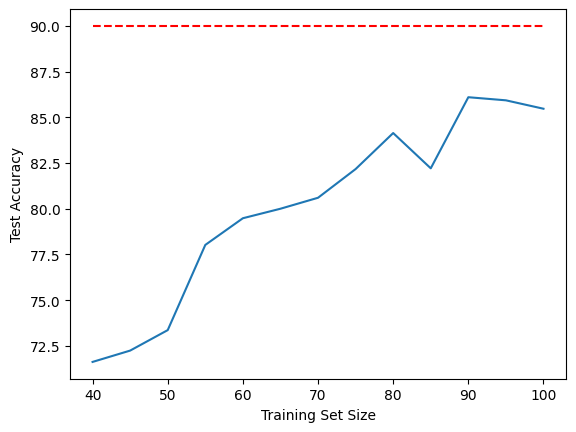

In [13]:
plt.plot(np.arange(start=num_initial_samples, stop=max_training_samples + acquisition_batch_size, step=acquisition_batch_size), test_accs)
plt.xlabel("Training Set Size")
plt.ylabel("Test Accuracy")
plt.hlines(90, num_initial_samples, max_training_samples, colors='r', linestyles='dashed')

plt.show()

## Storing results

In [14]:
params_dict = {
    'num_initial_samples': num_initial_samples,
    'num_classes': num_classes,
    'max_training_samples': max_training_samples,
    'acquisition_batch_size': acquisition_batch_size,
    'test_batch_size': test_batch_size,
    'batch_size': batch_size,
    'scoring_batch_size': scoring_batch_size,
    'training_iterations_nn': training_iterations_nn,
    'training_iterations_la': training_iterations_la,
}

save_experiment('random_K5', params_dict, {
    'test_accs': test_accs,
    'test_loss': test_loss,
    'added_indices': added_indices
})